In [34]:
# Basic imports
import os
import sys
import time
import timeit
import random
import pickle
import re
from itertools import product
import warnings

# System path modification
sys.path.insert(0, '..')
sys.path.insert(0, './src')

# Data handling
import pandas as pd
import numpy as np

# Machine learning imports
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.compose import ColumnTransformer, TransformedTargetRegressor
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import SimpleImputer, KNNImputer, IterativeImputer, MissingIndicator
from sklearn.model_selection import (
    train_test_split, KFold, StratifiedKFold, GroupKFold, StratifiedGroupKFold, LeaveOneOut, cross_validate, cross_val_score
)
from sklearn.linear_model import (
    LinearRegression, Lasso, LassoCV, MultiTaskLasso, MultiTaskLassoCV,
    ElasticNet, ElasticNetCV, MultiTaskElasticNet, MultiTaskElasticNetCV
)
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.multioutput import MultiOutputRegressor
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, explained_variance_score
from sklearn.cross_decomposition import PLSRegression
from sklearn.inspection import permutation_importance

from pytorch_tabnet.tab_model import TabNetRegressor
from missforest import MissForest

# Statistic imports 
from scipy.stats import ks_2samp
from scipy.special import kl_div
from scipy.cluster.hierarchy import linkage, leaves_list
from scipy.spatial.distance import pdist, squareform

# Specialized imputation and visualization packages
import miceforest as mf
import missingno as msno

# Custom modules
from src.gain import *
from src.train import *
from src.functions import *
from src.plots import *
from src.dataset import *
from src.multixgboost import *

# Visualizatiokn 
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
from matplotlib.ticker import FormatStrFormatter, ScalarFormatter, MaxNLocator
import seaborn as sns

# Ignore warnings
warnings.filterwarnings("ignore")

# Load data

In [35]:
df_X_original = pd.read_pickle('../pickle/df_X_original.pickle')
df_X = pd.read_pickle('../pickle/df_X_filtered.pickle')
df_y =  pd.read_pickle('../pickle/df_y_original.pickle')
df_all = pd.read_pickle('../pickle/df_all_original.pickle')
select = pd.read_pickle('../pickle/select_features.pickle')

miss_mask = pd.read_pickle('../pickle/filter_miss_mask.pickle')
miss_mask = miss_mask.tolist()

df_X[["APOE_epsilon2", "APOE_epsilon3", "APOE_epsilon4"]] = df_X[["APOE_epsilon2", "APOE_epsilon3", "APOE_epsilon4"]].astype("category")

df_all = df_all[miss_mask]
df_y = df_y[miss_mask]

results_pickle_folder = "../pickle"

## Colormaps for plot

In [36]:
full_palette_graph = {"orange": "#ff4b41", "yellow": "#ffaa41", "blue": "#75d8ff", 
                      "cyan": "#d7d341", "purple":"#e59edd", 
                      "green":"#70d941"}
gender_palette_tab = {
    "0": full_palette_graph["green"], 
    "1": full_palette_graph["purple"]
}
dx_palette_tab = {
    "CN": "#75d8ff",
    "MCI": "#ffcc92",
    "AD": "#ff4b41", 
}

gender_palette = gender_palette_tab
dx_palette = dx_palette_tab
full_palette = full_palette_graph
sns.color_palette(list(full_palette.values()))

[(1.0, 0.29411764705882354, 0.2549019607843137),
 (1.0, 0.6666666666666666, 0.2549019607843137),
 (0.4588235294117647, 0.8470588235294118, 1.0),
 (0.8431372549019608, 0.8274509803921568, 0.2549019607843137),
 (0.8980392156862745, 0.6196078431372549, 0.8666666666666667),
 (0.4392156862745098, 0.8509803921568627, 0.2549019607843137)]

# List Imputers

In [37]:
random_state=42
n_imputation_iter = 10

# Define hyperparameters
gain_parameters = {
    'hint_rate': 0.9,
    'alpha': 100,
    'iterations': 1000
}

# Continuous Imputer List (list of tuples with unique strings and corresponding instances)
continuous_imputer_list = [
    ("SimpleImputer_mean", SimpleImputer(strategy="mean")),
    ("KNNImputer", KNNImputer(n_neighbors=1)),
    ("KNNImputer_2", KNNImputer(n_neighbors=2)),
    ("KNNImputer_5", KNNImputer(n_neighbors=5)),
    ("IterativeImputer", IterativeImputer(max_iter=n_imputation_iter, random_state=random_state)),
    ("MissForest", MissForest(max_iter=n_imputation_iter)),
    ("GAINImputer", GAINImputer(**gain_parameters))
]

# Ordinal Imputer List (list of tuples with unique strings and corresponding instances)
ordinal_imputer_list = [
    ("SimpleImputer_most_frequent", SimpleImputer(strategy="most_frequent")),
    ("KNNImputer", KNNImputer(n_neighbors=1)),
    ("SimpleImputer_constant", SimpleImputer(strategy="constant", fill_value=-1))
]

# Predictive Models List (list of tuples with unique strings and corresponding instances)
predictive_models_list = [
    ("LinearRegression", LinearRegression()),
]

# Generate all combinations
combinations = list(product(continuous_imputer_list, ordinal_imputer_list, predictive_models_list))

# Display all combinations
for continuous_imputer, ordinal_imputer, model in combinations:
    print(f"Continuous Imputer: {continuous_imputer[0]}, Ordinal Imputer: {ordinal_imputer[0]}, Model: {model[0]}")

print(f"Combinations of preprocessing and models to test : {len(combinations)}")

Continuous Imputer: SimpleImputer_mean, Ordinal Imputer: SimpleImputer_most_frequent, Model: LinearRegression
Continuous Imputer: SimpleImputer_mean, Ordinal Imputer: KNNImputer, Model: LinearRegression
Continuous Imputer: SimpleImputer_mean, Ordinal Imputer: SimpleImputer_constant, Model: LinearRegression
Continuous Imputer: KNNImputer, Ordinal Imputer: SimpleImputer_most_frequent, Model: LinearRegression
Continuous Imputer: KNNImputer, Ordinal Imputer: KNNImputer, Model: LinearRegression
Continuous Imputer: KNNImputer, Ordinal Imputer: SimpleImputer_constant, Model: LinearRegression
Continuous Imputer: KNNImputer_2, Ordinal Imputer: SimpleImputer_most_frequent, Model: LinearRegression
Continuous Imputer: KNNImputer_2, Ordinal Imputer: KNNImputer, Model: LinearRegression
Continuous Imputer: KNNImputer_2, Ordinal Imputer: SimpleImputer_constant, Model: LinearRegression
Continuous Imputer: KNNImputer_5, Ordinal Imputer: SimpleImputer_most_frequent, Model: LinearRegression
Continuous Imp

# Compute imputed data distributions

In order to have a look at the features imputed by our different algorithms, we will just impute some of the data with the different algorithms on the training set with all the missing values to see if the distributions of imputed data do not diverge too much from the original ones. 

In [38]:
idx_train = list(df_X.isna().any(axis=1))
idx_test = list(~df_X.isna().any(axis=1))

set_intersect_rid = set(df_all[idx_train].RID).intersection(set(df_all[idx_test].RID))
intersect_rid_idx = df_all.RID.isin(set_intersect_rid)

for i, bool_test in enumerate(idx_test): 
    if intersect_rid_idx.iloc[i] & bool_test:
        idx_test[i] = False
        idx_train[i] = True

df_X_train = df_X.loc[idx_train]
df_X_test = df_X.loc[idx_test]

df_y_train = df_y.loc[idx_train]
df_y_test = df_y.loc[idx_test]

c_train = df_all[["AGE", "PTGENDER", "PTEDUCAT"]].iloc[idx_train]
c_test = df_all[["AGE", "PTGENDER", "PTEDUCAT"]].iloc[idx_test]

In [39]:
df_X_imputed_list = {"Original" : df_X_train}

ordinal_features = ['APOE_epsilon2', 'APOE_epsilon3', 'APOE_epsilon4']
continuous_features = [col for col in df_X_train.columns if col not in ordinal_features]

imputed_filename = "dict_imputed_df_X"

file_path = os.path.join(results_pickle_folder, f"{imputed_filename}.pickle")

if os.path.exists(file_path):
    print(f"The file '{imputed_filename}' already exists'.")
    with open(file_path, "rb") as file: 
        df_X_imputed_list = pd.read_pickle(file)
else:

    for imputer_name, continuous_imputer in continuous_imputer_list: 
        df_X_imputed = df_X_train.copy()

        continuous_imputer.fit(df_X_train[continuous_features])
        
        df_X_imputed[continuous_features] = continuous_imputer.transform(df_X_train[continuous_features])
        df_X_imputed_list[imputer_name] = df_X_imputed

    file_path = os.path.join(results_pickle_folder, f"{imputed_filename}.pickle")

    with open(file_path, 'wb') as file:
        pickle.dump(df_X_imputed_list, file)
    print(f"The dictionary has been saved as '{imputed_filename}.pkl' in the folder ''.")

The file 'dict_imputed_df_X' already exists'.


In [48]:
imputed_X_lst[i]

,ARG1,ATP8B5P || ZFAND6,C17ORF103,C6ORF25,CLU,CORO2B,CTNNB1,DACT1,ELOVL5,FOLR3,...,LH_Default_pCunPCC_1_Cortical,RH_Default_PFCdPFCm_6_Cortical,LH_Default_pCunPCC_2_Cortical,RH_Default_PFCdPFCm_7_Cortical,LH_Default_pCunPCC_3_Cortical,RH_Default_pCunPCC_1_Cortical,LH_Default_pCunPCC_4_Cortical,RH_Default_pCunPCC_2_Cortical,LH_Default_PHC_1_Cortical,RH_Default_pCunPCC_3_Cortical
11,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,2.044973,2.225490,2.155638,2.608966,2.557369,2.180390,2.232714,2.384730,1.707278,2.129071
12,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,2.029172,2.217474,2.108788,2.539391,2.625425,2.215119,2.197570,2.421708,1.746535,2.090786
13,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1.967125,2.216598,2.068816,2.592354,2.556477,2.145724,2.103739,2.344362,1.581183,2.035039
17,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,2.444347,2.619748,2.582679,2.506965,2.665064,2.678853,2.164981,2.579033,2.150521,2.182308
19,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,2.347611,2.499187,2.535837,2.370202,2.626769,2.588235,2.139122,2.450141,2.014049,2.089294
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9562,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,2.713503,2.051879,2.522892,2.187718,2.577351,2.651542,2.286221,2.474339,2.230404,2.249839
9573,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,2.389298,2.060905,2.413770,2.130438,2.659285,2.468979,2.325730,2.508589,2.102578,2.392047
9595,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,2.745870,2.226410,2.635547,2.154831,2.619080,2.973487,2.112136,2.597950,2.323369,2.353604
9611,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,2.610942,2.342472,2.678210,2.512056,2.488021,2.938747,2.524012,2.752840,2.391431,2.628268


In [47]:
pd.to_numeric(imputed_X_lst[i], errors='coerce')


TypeError: arg must be a list, tuple, 1-d array, or Series

TypeError: arg must be a list, tuple, 1-d array, or Series

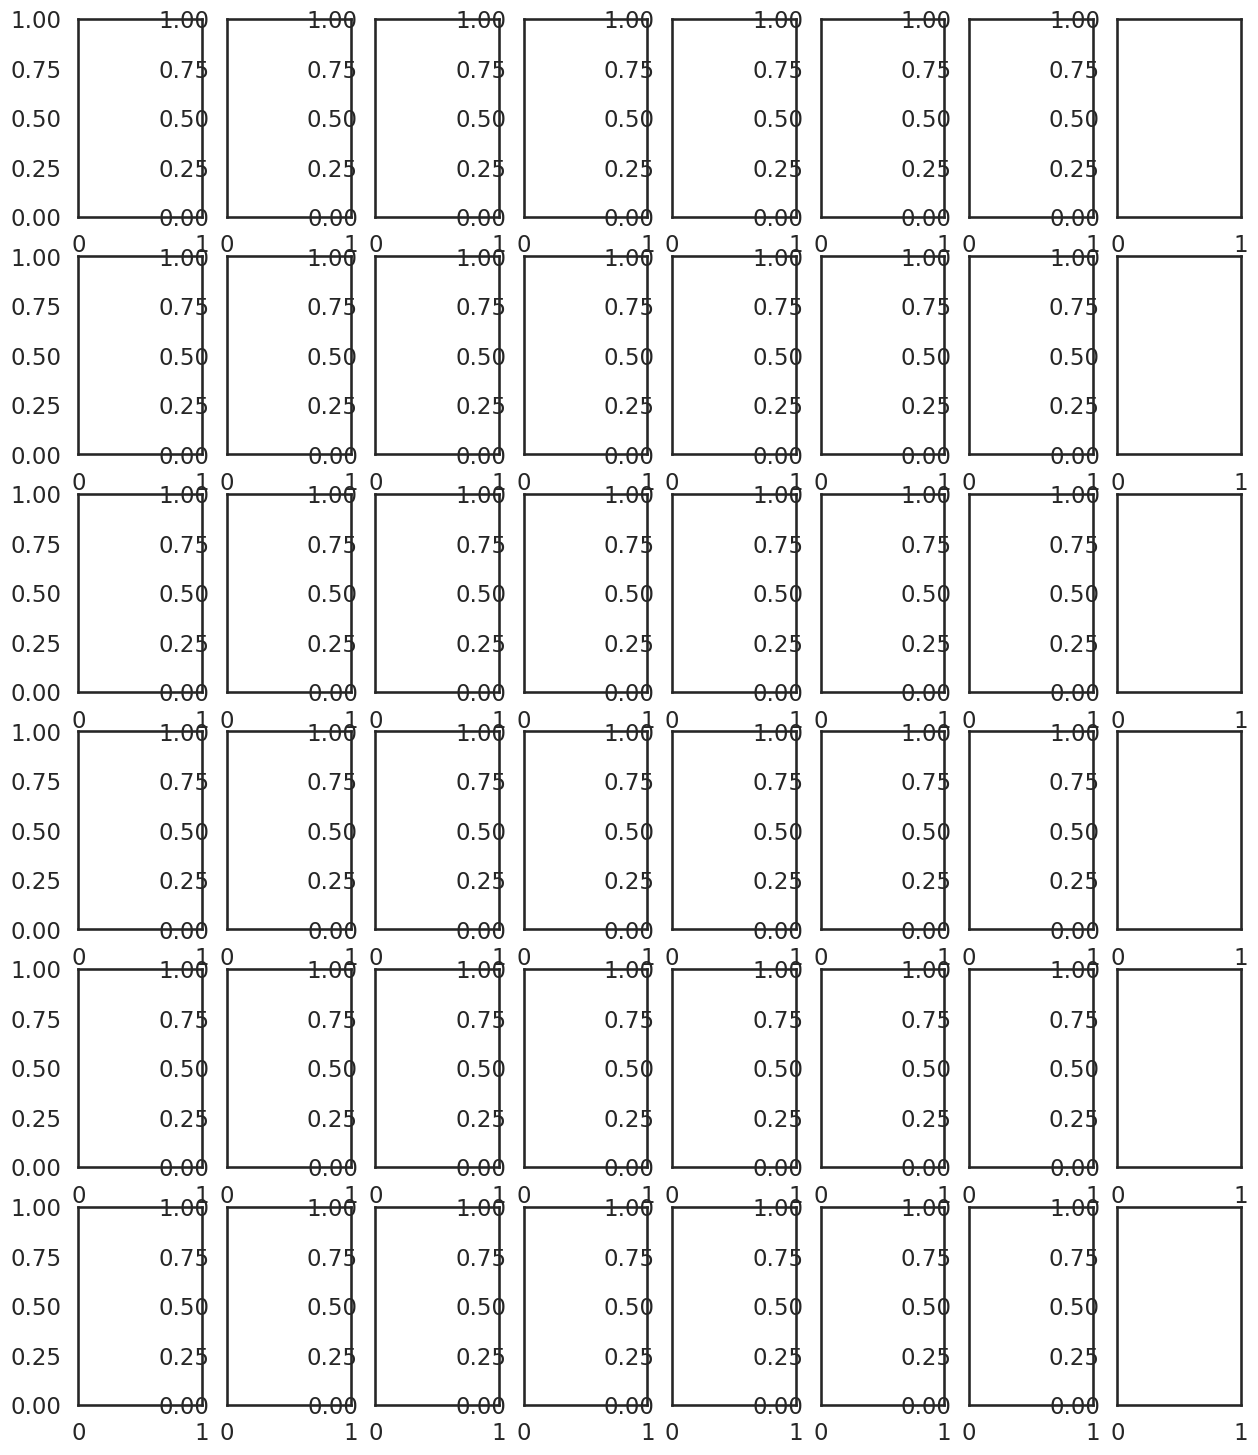

In [ ]:
cols = ['ABETA', 'TAU', 'PTAU', 'ARG1', 'CD300E', 'CLU']
cols_to_check = [df_X.columns.get_loc(col) for col in cols]

imputed_X_lst = list(df_X_imputed_list.values())
imputed_name_lst = list(df_X_imputed_list.keys())
random_cols_idx=cols_to_check
df_X0=None
hue_col=df_all.DX[idx_train]
n_plots=len(cols_to_check)
palette=dx_palette_tab

sns.set_style("white")
sns.set_context("talk")

if df_X0 is None:
    df_X0 = imputed_X_lst[0]

fig, axes = plt.subplots(nrows=n_plots, ncols=len(imputed_X_lst), figsize=(15, 18))

if random_cols_idx is None: 
    nacols = np.arange(df_X0.shape[1])[df_X0.isna().any()]
    random_cols_idx = random.sample(list(nacols), n_plots)

original_ticks = {}

for i in range(len(imputed_X_lst)):
    for j in range(n_plots):

        plt_i = random_cols_idx[j]
        plt_col = df_X0.columns.values[plt_i]

        plot_X = imputed_X_lst[i]

        plot_X = plot_X.apply(pd.to_numeric, errors='coerce')

        if imputed_name_lst[i] != "Original": 
            plot_X = plot_X[df_X0.isna()]
        else : 
            original_ticks[plt_col] = [np.floor(plot_X[plt_col].min()), np.floor(plot_X[plt_col].min() + plot_X[plt_col].max())/2, np.ceil(plot_X[plt_col].max())]

        if imputed_name_lst[i] != "SimpleImputer_mean":  
            sns.histplot(plot_X, x=plt_col, hue=hue_col, ax=axes[j][i], palette=palette, kde=True, legend=False)
        else: 
            sns.histplot(plot_X, x=plt_col, hue=hue_col, ax=axes[j][i], palette=palette, kde=False, legend=False)
            
        axes[j][i].set_xlabel('')
        axes[j][i].set_ylabel('')
        # Rotate the x-tick labels
        axes[j][i].set_xticklabels(axes[j][i].get_xticklabels(), rotation=60, ha='left', fontsize=14)
        axes[j][i].set_yticklabels(axes[j][i].get_yticklabels(), ha='right', fontsize=14)
        # Inside the nested loops where you handle individual axes:
        axes[j][i].xaxis.set_major_locator(MaxNLocator(nbins=2, integer=True))
        axes[j][i].tick_params(pad=0)


        sns.despine()

for ax, col in zip(axes[0], imputed_name_lst):
    ax.set_title(col.replace("SimpleImputer_mean", "MeanImputer").replace("_", " ").replace("Imputer", "\nImputer").replace("(", "\n("),
                  fontdict={"verticalalignment":"top"})

for ax, row in zip(axes[:, 0], df_X0.columns.values[random_cols_idx]):
    ax.set_ylabel(row.replace("_", " "), rotation=90, size='large')

if palette is not None:
    handles = [
        mlines.Line2D([], [], color=color, marker='o', linestyle='', markersize=16, label=label)
        for label, color in palette.items()
    ]
    fig.legend(
        handles=handles,
        loc='lower center',
        bbox_to_anchor=(0.5, 1.0),
        ncol=len(palette),
        title="",
        frameon=False
    )

#plt.tight_layout()
plt.subplots_adjust(hspace=0.4, wspace=0.4)

plt.savefig("../figures/imputation_distribution_plots.png", format="png", bbox_inches='tight')

In [ ]:
df_X_imputed_list
features_of_interest=cols
savefolder = "../figures/imputation"
heatmap_annot=True

original_df = df_X_imputed_list['Original']
ks_stats = {}
p_values = {}
kl_divergences = {}

In [ ]:
for method, imputed_df in df_X_imputed_list.items():
    print(method)

Original
SimpleImputer_mean
KNNImputer
IterativeImputer
MissForest
GAINImputer
KNNImputer(K=2)
KNNImputer(K=5)


In [ ]:
list(zip(df_X_imputed_list.keys(), full_palette_graph.values()))

[('Original', '#ff4b41'),
 ('SimpleImputer_mean', '#ffaa41'),
 ('KNNImputer', '#75d8ff'),
 ('IterativeImputer', '#d7d341'),
 ('MissForest', '#e59edd'),
 ('GAINImputer', '#70d941')]

In [ ]:
import matplotlib
for name, hex in list(zip(df_X_imputed_list.keys(), full_palette_graph.values())): 
    print(name)
    c_hex = matplotlib.colors.hex2color(hex)
    print([c*255 for c in c_hex])

Original
[255.0, 75.0, 65.0]
SimpleImputer_mean
[255.0, 170.0, 65.0]
KNNImputer
[117.0, 216.0, 255.0]
IterativeImputer
[215.0, 211.0, 65.0]
MissForest
[229.0, 158.0, 221.0]
GAINImputer
[112.0, 217.0, 65.0]


In [43]:
plot_X[plt_col]

11      NaN
12      NaN
13      NaN
17      NaN
19      NaN
       ... 
9562    0.0
9573    0.0
9595    1.0
9611    0.0
9615    0.0
Name: APOE_epsilon2, Length: 2882, dtype: category
Categories (3, float64): [0.0, 1.0, 2.0]

TypeError: Categorical is not ordered for operation min
you can use .as_ordered() to change the Categorical to an ordered one


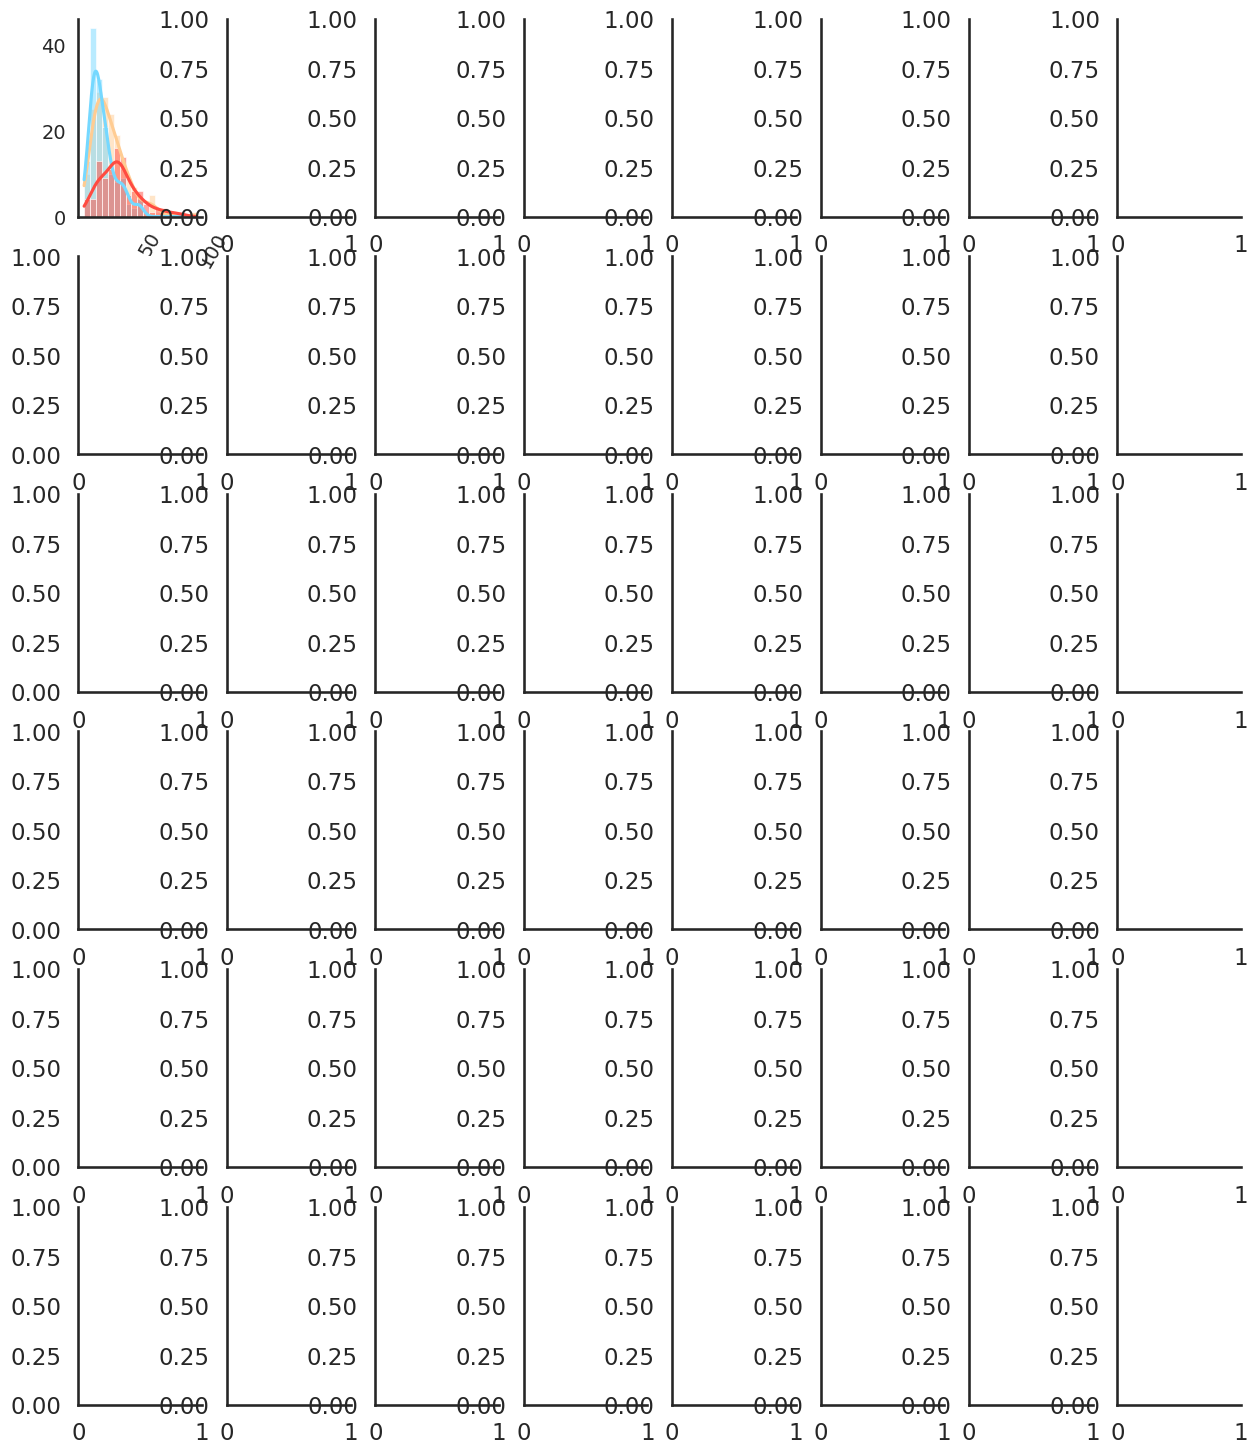

In [42]:
import matplotlib.lines as mlines
from matplotlib.ticker import FormatStrFormatter, ScalarFormatter, MaxNLocator

cols = ['ABETA', 'TAU', 'PTAU', 'ARG1', 'CD300E', 'CLU']
cols_to_check = [df_X.columns.get_loc(col) for col in cols]

imputed_X_lst = list(df_X_imputed_list.values())
imputed_name_lst = list(df_X_imputed_list.keys())
random_cols_idx=cols_to_check
df_X0=None
hue_col=df_all.DX[idx_train]
n_plots=len(cols_to_check)
palette=dx_palette_tab

sns.set_style("white")
sns.set_context("talk")

if df_X0 is None:
    df_X0 = imputed_X_lst[0]

fig, axes = plt.subplots(nrows=n_plots, ncols=len(imputed_X_lst), figsize=(15, 18))

if random_cols_idx is None: 
    nacols = np.arange(df_X0.shape[1])[df_X0.isna().any()]
    random_cols_idx = random.sample(list(nacols), n_plots)

original_ticks = {}

for i in range(len(imputed_X_lst)):
    for j in range(n_plots):

        plt_i = random_cols_idx[j]
        plt_col = df_X0.columns.values[plt_i]

        plot_X = imputed_X_lst[i]

        if imputed_name_lst[i] != "Original": 
            plot_X = plot_X[df_X0.isna()]
        else : 
            original_ticks[plt_col] = [np.floor(plot_X[plt_col].min()), np.floor(plot_X[plt_col].min() + plot_X[plt_col].max())/2, np.ceil(plot_X[plt_col].max())]

        if imputed_name_lst[i] != "SimpleImputer_mean":  
            sns.histplot(plot_X, x=plt_col, hue=hue_col, ax=axes[j][i], palette=palette, kde=True, legend=False)
        else: 
            sns.histplot(plot_X, x=plt_col, hue=hue_col, ax=axes[j][i], palette=palette, kde=False, legend=False)
            
        axes[j][i].set_xlabel('')
        axes[j][i].set_ylabel('')
        # Rotate the x-tick labels
        axes[j][i].set_xticklabels(axes[j][i].get_xticklabels(), rotation=60, ha='left', fontsize=14)
        axes[j][i].set_yticklabels(axes[j][i].get_yticklabels(), ha='right', fontsize=14)
        # Inside the nested loops where you handle individual axes:
        axes[j][i].xaxis.set_major_locator(MaxNLocator(nbins=2, integer=True))
        axes[j][i].tick_params(pad=0)


        sns.despine()

for ax, col in zip(axes[0], imputed_name_lst):
    ax.set_title(col.replace("SimpleImputer_mean", "MeanImputer").replace("_", " ").replace("Imputer", "\nImputer").replace("(", "\n("),
                  fontdict={"verticalalignment":"bottom"})

for ax, row in zip(axes[:, 0], df_X0.columns.values[random_cols_idx]):
    ax.set_ylabel(row.replace("_", " "), rotation=90, size='large')

if palette is not None:
    handles = [
        mlines.Line2D([], [], color=color, marker='o', linestyle='', markersize=16, label=label)
        for label, color in palette.items()
    ]
    fig.legend(
        handles=handles,
        loc='lower center',
        bbox_to_anchor=(0.5, 1.0),
        ncol=len(palette),
        title="",
        frameon=False
    )

#plt.tight_layout()
plt.subplots_adjust(hspace=0.4, wspace=0.4)

plt.savefig("../figures/imputation_distribution_plots.png", format="png", bbox_inches='tight')

In [41]:
# Prepare grids for subplots
num_features = len(features_of_interest)
nrows = (num_features + 2) // 3  # Adjust rows based on the number of features
ncols = 3

# Increase figure width
fig, axes = plt.subplots(nrows, ncols, figsize=(12, 8))

sns.set_style("white")
sns.set_context("talk")

axes = axes.flatten()

for i, feature_name in enumerate(features_of_interest):
    ks_stats[feature_name] = {}
    p_values[feature_name] = {}
    kl_divergences[feature_name] = {}
    
    original_clean = original_df[feature_name].dropna()  # Non-missing values in the original data
    missing_indices = original_df[feature_name].isna()  # Missing indices in the original data

    # Prepare ECDF data
    ecdf_data = pd.DataFrame()
    for method, imputed_df in df_X_imputed_list.items():
        if method == 'Original':
            continue  # Skip the original dataset
        
        # Extract imputed values at missing indices
        imputed_values = imputed_df.loc[missing_indices, feature_name]
        
        # KS Test
        ks_stat, p_value = ks_2samp(original_clean, imputed_values)
        ks_stats[feature_name][method] = ks_stat
        p_values[feature_name][method] = p_value

        # Compute histograms for KL Divergence
        bins = np.histogram_bin_edges(original_clean, bins="fd")  # Freedman-Diaconis rule
        original_hist, _ = np.histogram(original_clean, bins=bins, density=True)
        imputed_hist, _ = np.histogram(imputed_values, bins=bins, density=True)

        # Avoid division by zero
        original_hist += 1e-9
        imputed_hist += 1e-9

        kl_div_value = np.sum(kl_div(original_hist, imputed_hist))
        kl_divergences[feature_name][method] = kl_div_value

        # Add to ECDF data
        temp_df = pd.DataFrame({
            'Value': np.sort(imputed_values),
            'ECDF': np.arange(len(imputed_values)) / len(imputed_values),
            'Method': method
        })
        ecdf_data = pd.concat([ecdf_data, temp_df])
    
    # Add original ECDF
    ecdf_data = pd.concat([
        ecdf_data,
        pd.DataFrame({
            'Value': np.sort(original_clean),
            'ECDF': np.arange(len(original_clean)) / len(original_clean),
            'Method': 'Original'
        })
    ])
    
    # Plot ECDF in subplot
    sns.lineplot(data=ecdf_data, x="Value", y="ECDF", hue="Method", ax=axes[i], palette=sns.color_palette("Set1"), linewidth=3, alpha=0.8)
    axes[i].set_title(f'{feature_name}')
    axes[i].set_xlabel('')
    axes[i].set_ylabel('ECDF')
    axes[i].get_legend().remove()  # Remove individual legends from subplots
    sns.despine()

# Hide unused subplots
for j in range(i + 1, len(axes)):
    axes[j].axis('off')

# Add a single legend at the bottom of the figure
handles, labels = axes[0].get_legend_handles_labels()
labels = [l.replace("SimpleImputer_mean", "MeanImputer").replace("Imputer", " Imputer").replace("_", " ").replace("(", " (") for l in labels]
fig.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.5, 1.15), ncol=len(labels), ncols=4, title="Imputation Method", frameon=False, fontsize=16, title_fontsize=18)

# Adjust layout
plt.tight_layout(rect=[0, 0.05, 1.05, 1])  # Leave space for the legend

# Save and show the figure
if savefolder is not None:
    plt.savefig(f"{savefolder}_ecdf_plot.png", format="png", bbox_inches='tight')

plt.show()

NameError: name 'features_of_interest' is not defined

In [ ]:
# Convert results to DataFrames for heatmaps
ks_stats_df = pd.DataFrame(ks_stats).T
p_values_df = pd.DataFrame(p_values).T
kl_divergences_df = pd.DataFrame(kl_divergences).T

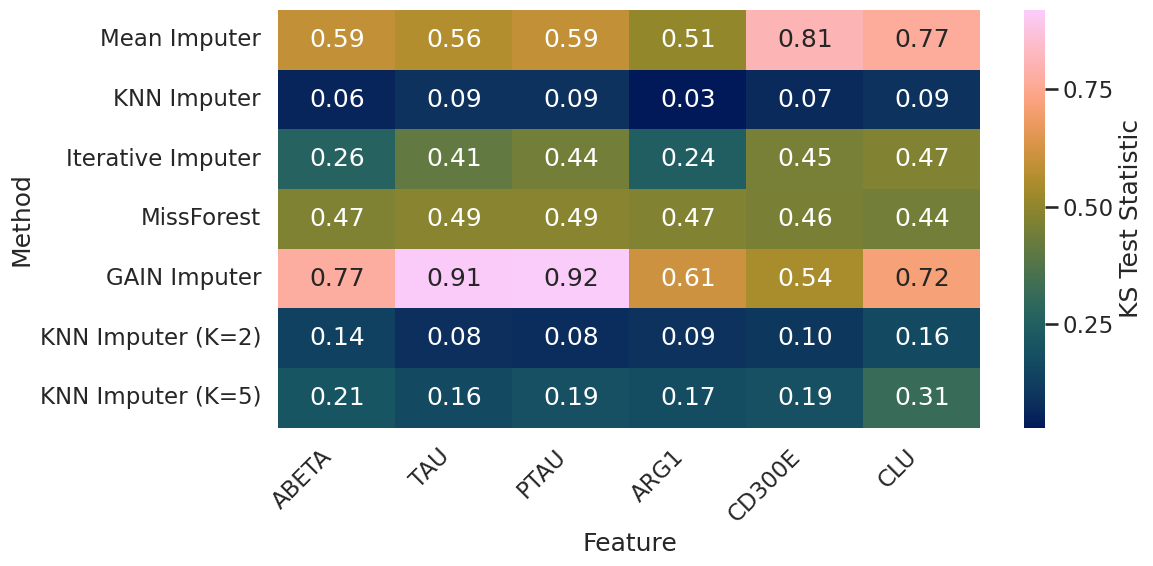

In [ ]:
# KS Statistics Heatmap
plt.figure(figsize=(12, 6))

# Create the heatmap
ax = sns.heatmap(
    ks_stats_df.transpose(), 
    annot=heatmap_annot, 
    fmt=".2f", 
    cmap=cm_seq, 
    cbar_kws={'label': 'KS Test Statistic', 'ticks': [0.0, 0.25, 0.5, 0.75, 1.0]}  # Fewer ticks
)

# Remove underscores from y-axis tick labels
yticklabels = [label.get_text().replace("SimpleImputer_mean", "MeanImputer").replace("Imputer", " Imputer").replace("_", " ").replace("(", " (") for label in ax.get_yticklabels()]
ax.set_yticklabels(yticklabels)

# Tilt x-axis labels by 45 degrees
plt.xticks(rotation=45, ha='right')

# Adjust labels and layout
plt.ylabel("Method")
plt.xlabel("Feature")
plt.tight_layout()

# Save the plot
if savefolder is not None: 
    plt.savefig(f"{savefolder}_ks_statistic_heatmap.png", format="png")

plt.show()


In [ ]:
p_values_df

,SimpleImputer_mean,KNNImputer,IterativeImputer,MissForest,GAINImputer,KNNImputer(K=2),KNNImputer(K=5)
ABETA,9.662637e-118,0.197497,2.455229e-22,5.656318e-72,8.248551e-220,3.012540e-06,6.452317e-14
TAU,4.143505e-106,0.006430,5.887505e-55,4.137847e-78,3.458460e-322,1.705714e-02,1.153709e-08
PTAU,3.955109e-118,0.006797,1.968154e-64,4.513845e-78,3.063207e-322,3.070154e-02,9.988902e-12
ARG1,7.430959e-169,0.581310,5.551000e-38,1.656907e-145,3.034372e-248,1.339253e-05,5.280384e-19
CD300E,0.000000e+00,0.002586,1.555398e-133,1.137382e-136,6.246192e-195,5.299607e-07,5.492291e-23
CLU,0.000000e+00,0.000019,9.432642e-144,4.634757e-127,3.260833e-322,6.193838e-17,7.932534e-63


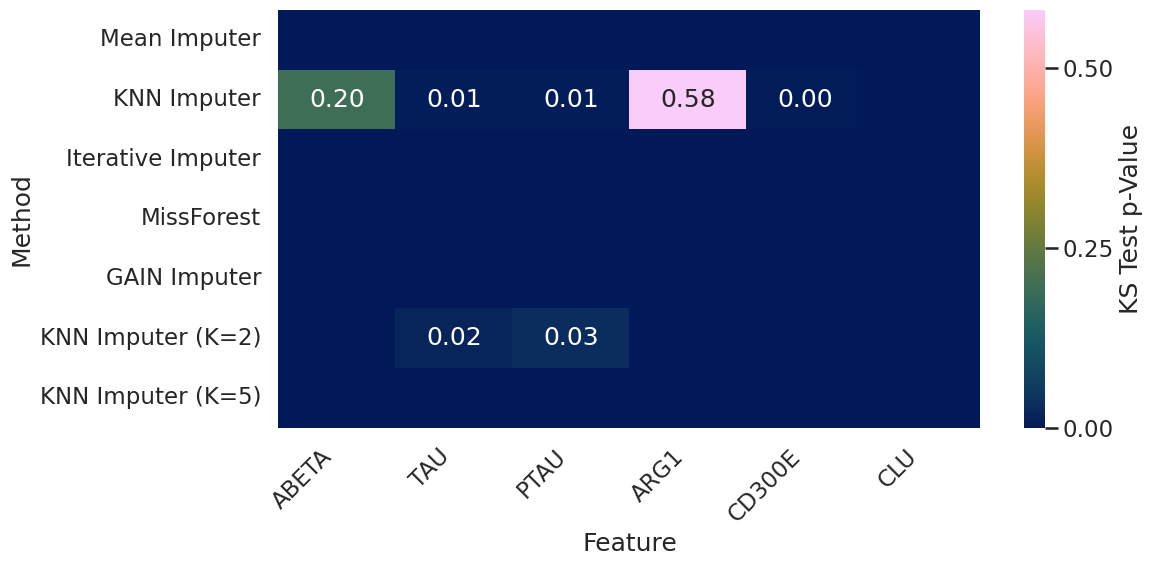

In [ ]:
# KS Statistics Heatmap
plt.figure(figsize=(12, 6))

# Define a threshold for annotation (e.g., values greater than 0.5)
threshold = 0.001

# Prepare the annotation matrix, but ensure proper formatting for non-empty strings
annotations = p_values_df.transpose().applymap(lambda x: f"{x:.2f}" if x > threshold else "")

# Create the heatmap with conditional annotations
ax = sns.heatmap(
    p_values_df.transpose(), 
    annot=annotations,  # Use the prepared annotations
    fmt="",  # Disable the default formatting (because we've handled it in annotations)
    cmap=cm_seq, 
    cbar_kws={'label': 'KS Test p-Value', 'ticks': [0.0, 0.25, 0.5, 0.75, 1.0]},  # Fewer ticks
)

# Remove underscores from y-axis tick labels
yticklabels = [label.get_text().replace("SimpleImputer_mean", "MeanImputer").replace("Imputer", " Imputer").replace("_", " ").replace("(", " (") for label in ax.get_yticklabels()]
ax.set_yticklabels(yticklabels)

# Tilt x-axis labels by 45 degrees
plt.xticks(rotation=45, ha='right')

# Adjust labels and layout
plt.ylabel("Method")
plt.xlabel("Feature")
plt.tight_layout()

# Save the plot
if savefolder is not None: 
    plt.savefig(f"{savefolder}_ks_pvalues_heatmap.png", format="png")

plt.show()


In [ ]:
kl_divergences_df.describe()

,SimpleImputer_mean,KNNImputer,IterativeImputer,MissForest,GAINImputer,KNNImputer(K=2),KNNImputer(K=5)
count,6.000000,6.000000,6.000000,6.000000,6.000000,6.000000,6.000000
mean,58.692678,0.360840,8.670631,37.756461,53.735337,1.898069,4.438797
std,74.726923,0.475697,9.606474,42.416999,64.435908,3.303777,6.121562
min,0.063006,0.000137,0.002391,0.047689,0.066965,0.000979,0.004567
25%,0.981343,0.004629,0.447468,0.859121,1.061006,0.011076,0.057388
50%,38.309087,0.178561,5.977577,30.538259,39.665672,0.349854,2.184210
75%,82.961106,0.548776,16.856782,64.796929,81.771689,1.881649,6.010175
max,189.091016,1.188949,20.978960,98.231996,159.013902,8.397328,15.625852


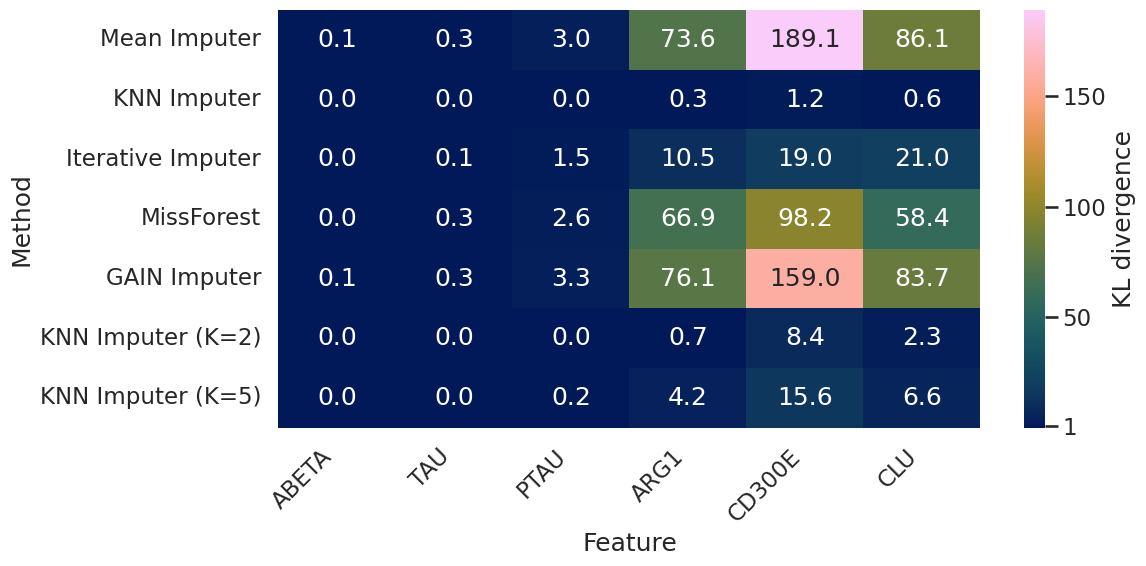

In [ ]:
# KS Statistics Heatmap
plt.figure(figsize=(12, 6))

# Define a threshold for annotation (e.g., values greater than 0.5)
threshold = 0

# Prepare the annotation matrix, but ensure proper formatting for non-empty strings
annotations = kl_divergences_df.transpose().applymap(lambda x: f"{x:.1f}" if x > threshold else "")

# Create the heatmap with conditional annotations
ax = sns.heatmap(
    kl_divergences_df.transpose(), 
    annot=annotations,  # Use the prepared annotations
    fmt="",  # Disable the default formatting (because we've handled it in annotations)
    cmap=cm_seq, 
    cbar_kws={'label':'KL divergence','ticks': [1., 50.0, 100., 150.]},  # Fewer ticks
)

# Remove underscores from y-axis tick labels
yticklabels = [label.get_text().replace("SimpleImputer_mean", "MeanImputer").replace("Imputer", " Imputer").replace("_", " ").replace("(", " (") for label in ax.get_yticklabels()]
ax.set_yticklabels(yticklabels)

# Tilt x-axis labels by 45 degrees
plt.xticks(rotation=45, ha='right')

# Adjust labels and layout
plt.ylabel("Method")
plt.xlabel("Feature")
plt.tight_layout()

# Save the plot
if savefolder is not None: 
    plt.savefig(f"{savefolder}_kldivergence_heatmap.png", format="png")

plt.show()

### Order columns by KL divergence and KS test

In [ ]:
kl_divergences_df.mean().sort_values()

KNNImputer             0.360840
KNNImputer(K=2)        1.898069
KNNImputer(K=5)        4.438797
IterativeImputer       8.670631
MissForest            37.756461
GAINImputer           53.735337
SimpleImputer_mean    58.692678
dtype: float64

In [ ]:
p_values_df.mean().sort_values(ascending=False)

KNNImputer             1.324399e-01
KNNImputer(K=2)        7.962602e-03
KNNImputer(K=5)        1.924523e-09
IterativeImputer       4.092048e-23
MissForest             9.427211e-73
SimpleImputer_mean    6.905842e-107
GAINImputer           1.041032e-195
dtype: float64

In [ ]:
ks_stats_df.mean().sort_values()

KNNImputer            0.069963
KNNImputer(K=2)       0.108048
KNNImputer(K=5)       0.205574
IterativeImputer      0.380990
MissForest            0.469347
SimpleImputer_mean    0.637003
GAINImputer           0.746147
dtype: float64

# Sort the imputed_X_lst according to the sorted KL divergence. 

In [ ]:
sort_imp = kl_divergences_df.mean().sort_values().index
sort_dict = dict(zip(sort_imp, range(1, len(sort_imp)+1)))

In [ ]:
# Sort the rest of the list (excluding the first element)
sorted_indices = sorted(range(1, len(imputed_name_lst)), key=lambda x: sort_dict[imputed_name_lst[x]])

# Recreate the sorted list with the first element in its original position
sorted_imputed_name_lst = [imputed_name_lst[0]] + [imputed_name_lst[i] for i in sorted_indices]

# Recreate the sorted list with the first element in its original position
sorted_imputed_X_lst = [imputed_X_lst[0]] + [imputed_X_lst[i] for i in sorted_indices]

print(sorted_imputed_name_lst)


['Original', 'KNNImputer', 'KNNImputer(K=2)', 'KNNImputer(K=5)', 'IterativeImputer', 'MissForest', 'GAINImputer', 'SimpleImputer_mean']


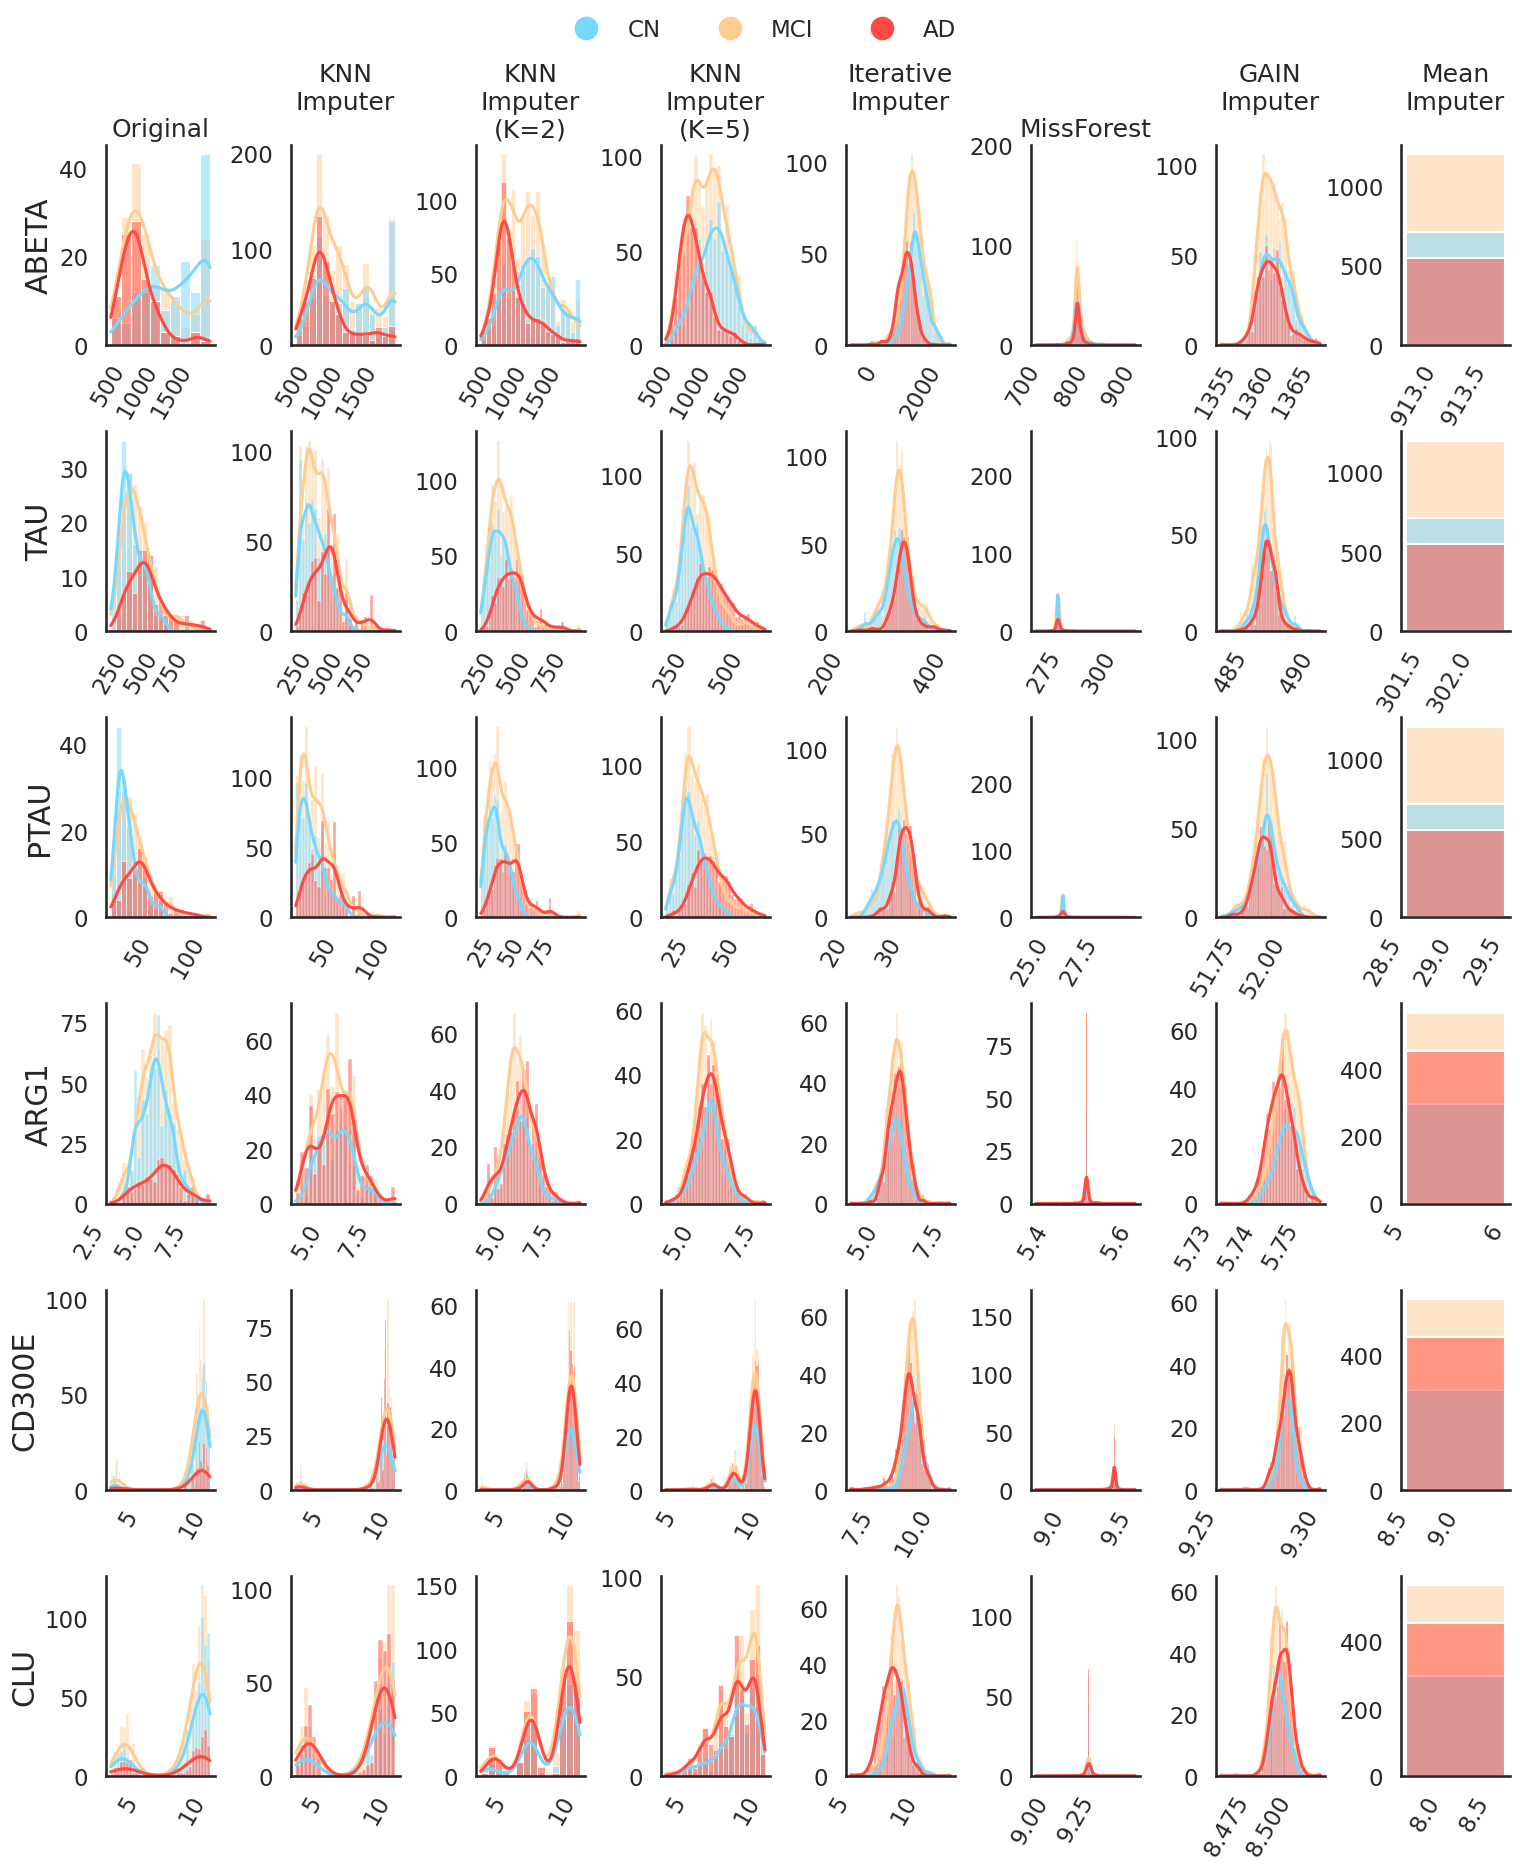

In [ ]:
from matplotlib.ticker import ScalarFormatter

sns.set_style("white")
sns.set_context("talk")

if df_X0 is None:
    df_X0 = sorted_imputed_X_lst[0]

fig, axes = plt.subplots(nrows=n_plots, ncols=len(sorted_imputed_X_lst), figsize=(15, 18))

if random_cols_idx is None: 
    nacols = np.arange(df_X0.shape[1])[df_X0.isna().any()]
    random_cols_idx = random.sample(list(nacols), n_plots)

original_ticks = {}

for i in range(len(sorted_imputed_X_lst)):
    for j in range(n_plots):

        plt_i = random_cols_idx[j]
        plt_col = df_X0.columns.values[plt_i]

        plot_X = sorted_imputed_X_lst[i]

        if sorted_imputed_name_lst[i] != "Original": 
            plot_X = plot_X[df_X0.isna()]
        else : 
            original_ticks[plt_col] = [np.floor(plot_X[plt_col].min()), np.floor(plot_X[plt_col].min() + plot_X[plt_col].max())/2, np.ceil(plot_X[plt_col].max())]

        if sorted_imputed_name_lst[i] != "SimpleImputer_mean":  
            sns.histplot(plot_X, x=plt_col, hue=hue_col, ax=axes[j][i], palette=palette, kde=True, legend=False)
        else: 
            sns.histplot(plot_X, x=plt_col, hue=hue_col, ax=axes[j][i], palette=palette, kde=False, legend=False)
            
        axes[j][i].set_xlabel('')
        axes[j][i].set_ylabel('')
        # Rotate the x-tick labels
        axes[j][i].set_xticklabels(axes[j][i].get_xticklabels(), rotation=60, ha='right')
        # Inside the nested loops where you handle individual axes:
        axes[j][i].xaxis.set_major_formatter(ScalarFormatter(useMathText=True))


        sns.despine()

for ax, col in zip(axes[0], sorted_imputed_name_lst):
    ax.set_title(col.replace("_", " ").replace("SimpleImputer mean", "MeanImputer").replace("Imputer", "\nImputer\n"))

for ax, row in zip(axes[:, 0], df_X0.columns.values[random_cols_idx]):
    ax.set_ylabel(row.replace("_", " "), rotation=90, size='large')

if palette is not None:
    handles = [
        mlines.Line2D([], [], color=color, marker='o', linestyle='', markersize=16, label=label)
        for label, color in palette.items()
    ]
    fig.legend(
        handles=handles,
        loc='lower center',
        bbox_to_anchor=(0.5, 1.0),
        ncol=len(palette),
        title="",
        frameon=False
    )

plt.tight_layout(pad=0.0)

plt.savefig("../figures/imputation_distribution_plots.png", format="png", bbox_inches='tight')

# Select preprocessing and transforms using Linear Regression as evaluation  model

In [ ]:
idx_train = list(df_X.isna().any(axis=1))
idx_test = list(~df_X.isna().any(axis=1))

Some of the patients with no missing values in the test set are present in the training set so we will remove them from training. 

In [ ]:
set_intersect_rid = set(df_all[idx_train].RID).intersection(set(df_all[idx_test].RID))
intersect_rid_idx = df_all.RID.isin(set_intersect_rid)

In [ ]:
for i, bool_test in enumerate(idx_test): 
    if intersect_rid_idx.iloc[i] & bool_test:
        idx_test[i] = False
        idx_train[i] = True

In [ ]:
set(df_all[idx_train].RID).intersection(set(df_all[idx_test].RID))

set()

<Axes: >

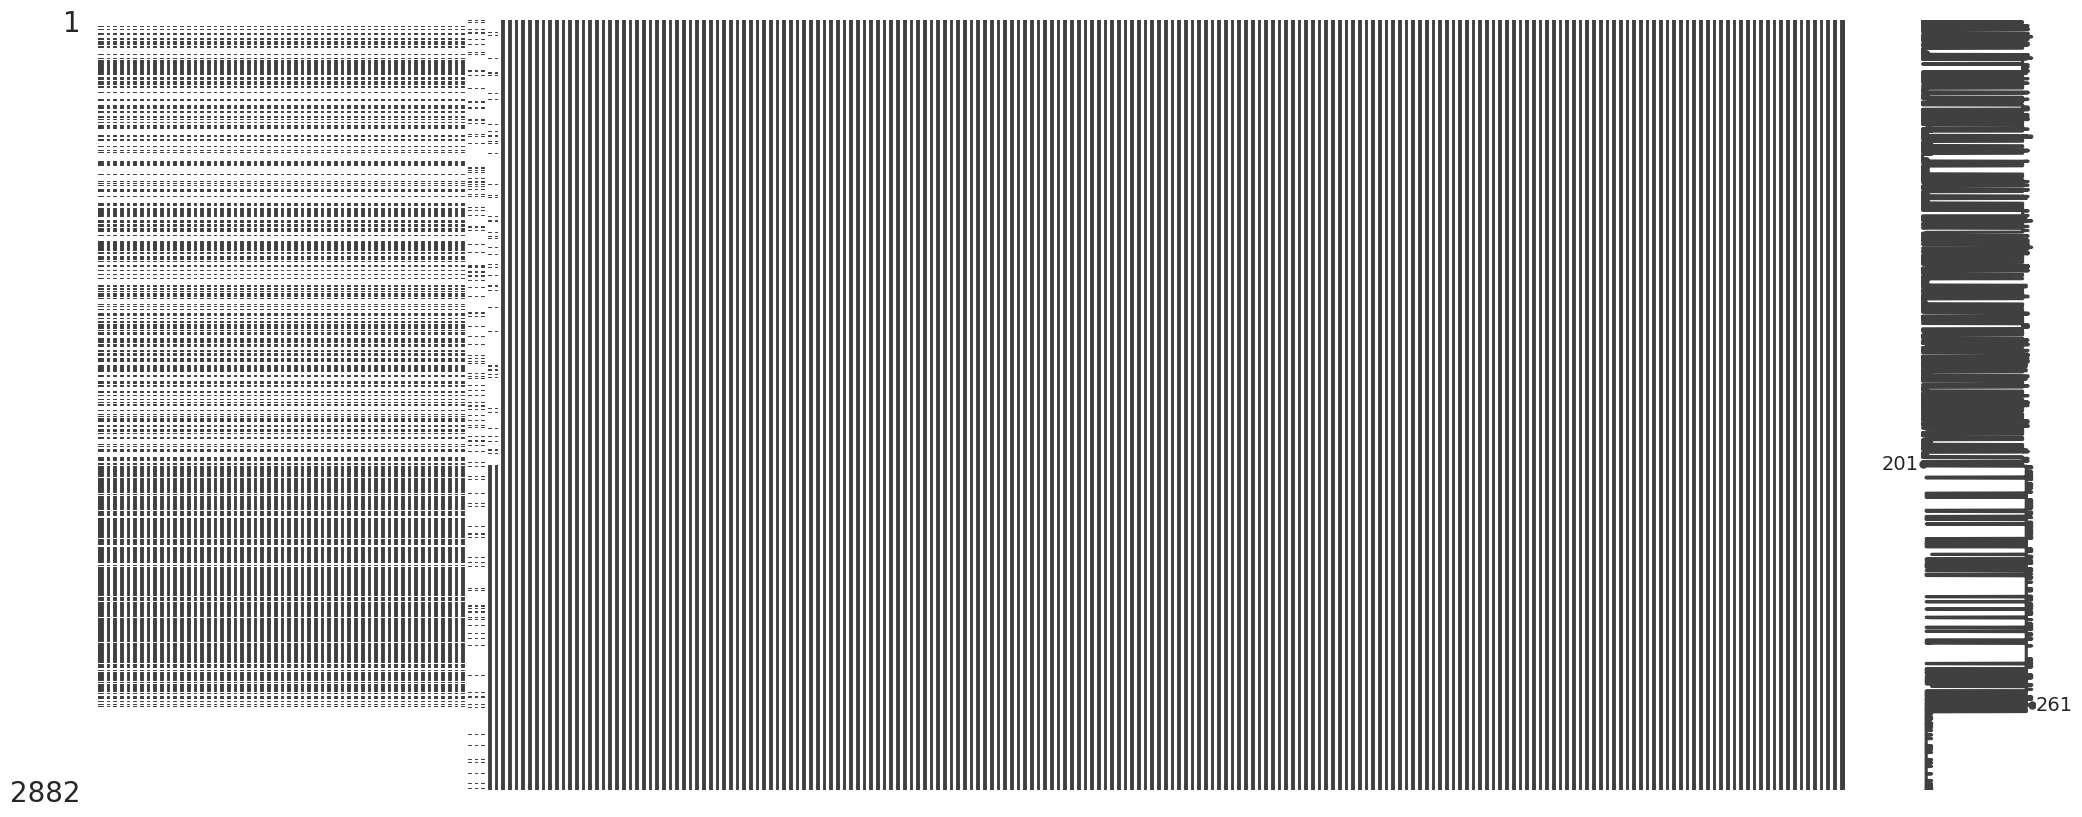

In [ ]:
msno.matrix(df_X[idx_train])

<Axes: >

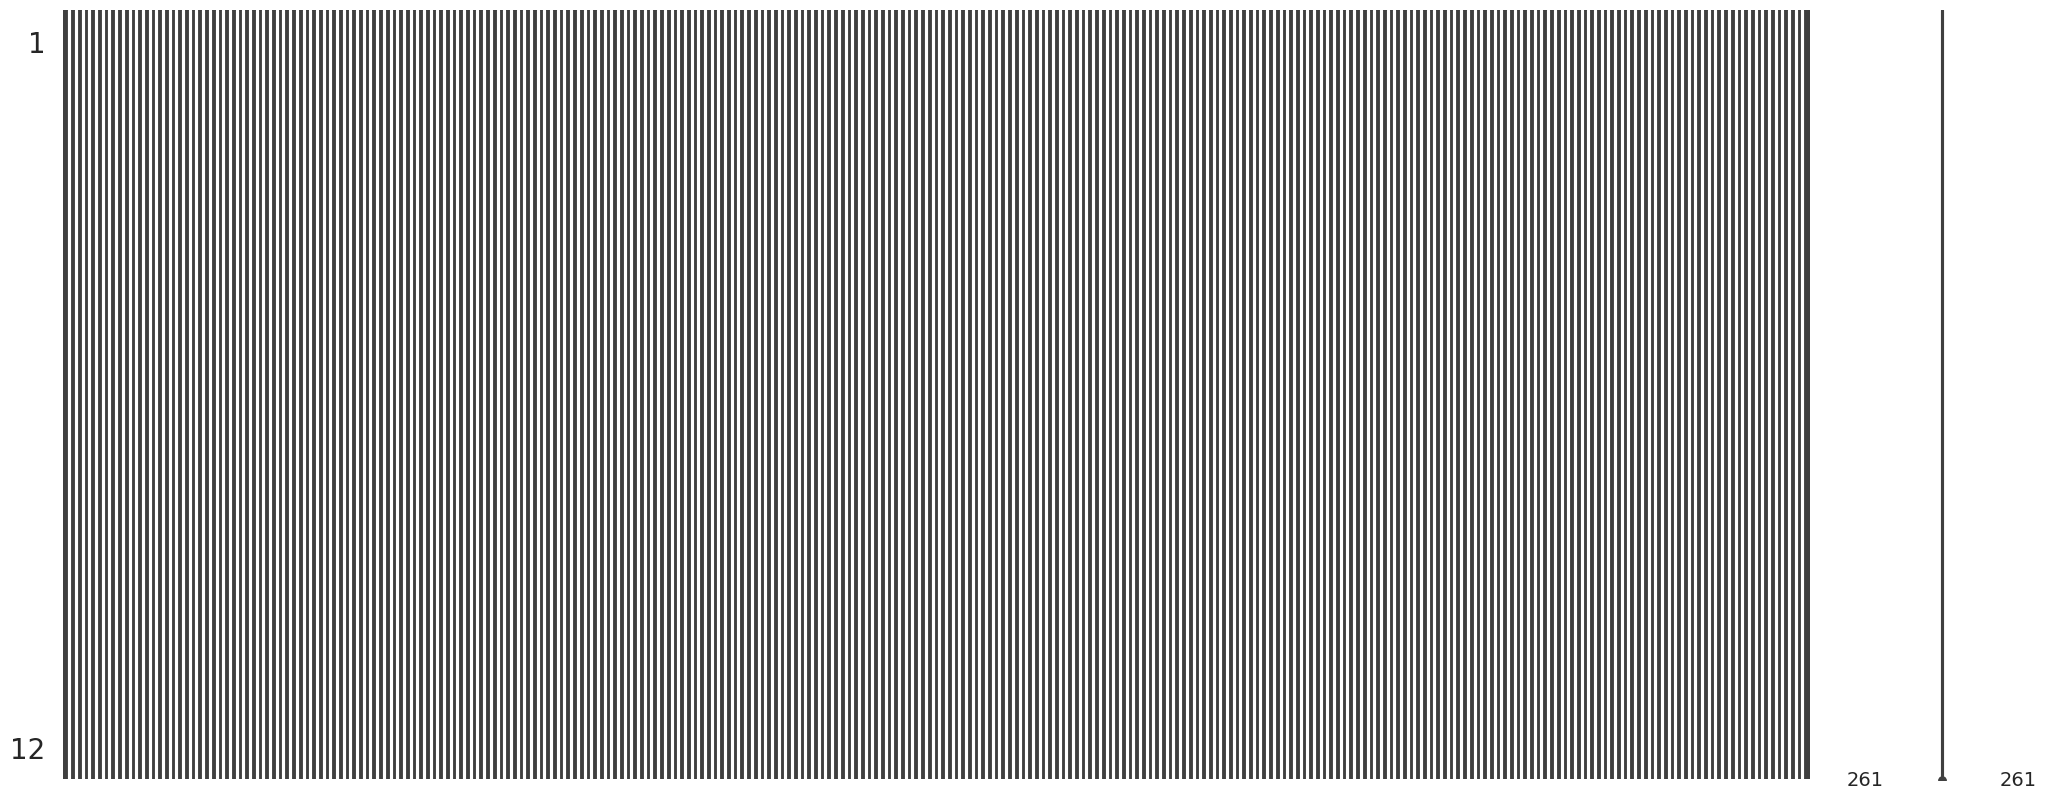

In [ ]:
msno.matrix(df_X[idx_test])

In [ ]:
sum(idx_train) + sum(idx_test) == df_X.shape[0]

True

In [ ]:
df_X_train = df_X.loc[idx_train]
df_X_test = df_X.loc[idx_test]

df_y_train = df_y.loc[idx_train]
df_y_test = df_y.loc[idx_test]

c_train = df_all[["AGE", "PTGENDER", "PTEDUCAT"]].iloc[idx_train]
c_test = df_all[["AGE", "PTGENDER", "PTEDUCAT"]].iloc[idx_test]

ordinal_features = ['APOE_epsilon2', 'APOE_epsilon3', 'APOE_epsilon4']
continuous_features = [col for col in df_X_train.columns if col not in ordinal_features]

In [ ]:
random_state=42
n_imputation_iter = 10

# Define hyperparameters
gain_parameters = {
    'hint_rate': 0.9,
    'alpha': 100,
    'iterations': 1000
}

# Continuous Imputer List (list of tuples with unique strings and corresponding instances)
continuous_imputer_list = [
    ("SimpleImputer_mean", SimpleImputer(strategy="mean")),
    ("KNNImputer", KNNImputer(n_neighbors=1)),
    ("KNNImputer_2", KNNImputer(n_neighbors=2)),
    ("KNNImputer_5", KNNImputer(n_neighbors=5)),
    ("IterativeImputer", IterativeImputer(max_iter=n_imputation_iter, random_state=random_state)),
    ("MissForest", MissForest(max_iter=n_imputation_iter)),
    ("GAINImputer", GAINImputer(**gain_parameters))
]

# Ordinal Imputer List (list of tuples with unique strings and corresponding instances)
ordinal_imputer_list = [
    ("SimpleImputer_most_frequent", SimpleImputer(strategy="most_frequent")),
    ("KNNImputer", KNNImputer(n_neighbors=1)),
    ("SimpleImputer_constant", SimpleImputer(strategy="constant", fill_value=-1))
]

# Predictive Models List (list of tuples with unique strings and corresponding instances)
predictive_models_list = [
    ("LinearRegression", LinearRegression()),
]

# Generate all combinations
combinations = list(product(continuous_imputer_list, ordinal_imputer_list, predictive_models_list))

# Display all combinations
for continuous_imputer, ordinal_imputer, model in combinations:
    print(f"Continuous Imputer: {continuous_imputer[0]}, Ordinal Imputer: {ordinal_imputer[0]}, Model: {model[0]}")

print(f"Combinations of preprocessing and models to test : {len(combinations)}")

Continuous Imputer: SimpleImputer_mean, Ordinal Imputer: SimpleImputer_most_frequent, Model: LinearRegression
Continuous Imputer: SimpleImputer_mean, Ordinal Imputer: KNNImputer, Model: LinearRegression
Continuous Imputer: SimpleImputer_mean, Ordinal Imputer: SimpleImputer_constant, Model: LinearRegression
Continuous Imputer: KNNImputer, Ordinal Imputer: SimpleImputer_most_frequent, Model: LinearRegression
Continuous Imputer: KNNImputer, Ordinal Imputer: KNNImputer, Model: LinearRegression
Continuous Imputer: KNNImputer, Ordinal Imputer: SimpleImputer_constant, Model: LinearRegression
Continuous Imputer: KNNImputer_2, Ordinal Imputer: SimpleImputer_most_frequent, Model: LinearRegression
Continuous Imputer: KNNImputer_2, Ordinal Imputer: KNNImputer, Model: LinearRegression
Continuous Imputer: KNNImputer_2, Ordinal Imputer: SimpleImputer_constant, Model: LinearRegression
Continuous Imputer: KNNImputer_5, Ordinal Imputer: SimpleImputer_most_frequent, Model: LinearRegression
Continuous Imp

In [ ]:
results_file = './6.1.2_missingnesss_aware_selection_pickle/training_1_dict_results.pickle'

In [ ]:
with open('./6.1.2_missingnesss_aware_selection_pickle/training_1_dict_results.pickle', "rb") as input_file:
    all_dict_results = pickle.load(input_file)

In [ ]:
if True: 

    with open('./6.1.2_missingnesss_aware_selection_pickle/training_1_dict_results.pickle', "rb") as input_file:
        all_dict_results = pickle.load(input_file)

    for continuous_imputer, ordinal_imputer, model in combinations:
        name_continuous_imputer, continuous_imputer_instance = continuous_imputer
        name_ordinal_imputer, ordinal_imputer_instance = ordinal_imputer
        name_model, model_instance = model

        params = {
            "ordinal_imputer": name_ordinal_imputer, 
            "continuous_imputer": name_continuous_imputer, 
            "model": name_model, "train_shape" : df_X_train.shape, 
            "test_shape": df_X_test.shape
        }

        if any(result['params'] == params for result in all_dict_results):
            # Skip this iteration if the combination exists
            print(f"Skipping existing combination: {params.values()}")
            
            continue

        try: 
        
            # Now you can call your `train_model` function with these components
            dict_results = train_imputer_model(
                df_X_train, df_X_test, df_y_train, df_y_test,
                c_train, c_test,
                ordinal_imputer_instance, name_ordinal_imputer,
                continuous_imputer_instance, name_continuous_imputer,
                model_instance, name_model,
                separate_imputers=True  # Or however you want to specify
            )

        except Exception as e:  

            print(e)
        
            dict_results = {
            "params": params, 
            "imputation_time": None,
            "fitting_time": None, 
            "results_adj": None, 
            "results_org": None
        }
            
        print(dict_results)
            
        # Optionally keep the all_dict_results list updated
        all_dict_results.append(dict_results)

            # Save the updated results back to the pickle file
        with open(results_file, 'wb') as f:
            pickle.dump(all_dict_results, f)


Skipping existing combination: dict_values(['SimpleImputer_most_frequent', 'SimpleImputer_mean', 'LinearRegression', (2882, 261), (12, 261)])
Skipping existing combination: dict_values(['KNNImputer', 'SimpleImputer_mean', 'LinearRegression', (2882, 261), (12, 261)])
Skipping existing combination: dict_values(['SimpleImputer_constant', 'SimpleImputer_mean', 'LinearRegression', (2882, 261), (12, 261)])
Skipping existing combination: dict_values(['SimpleImputer_most_frequent', 'KNNImputer', 'LinearRegression', (2882, 261), (12, 261)])
Skipping existing combination: dict_values(['KNNImputer', 'KNNImputer', 'LinearRegression', (2882, 261), (12, 261)])
Skipping existing combination: dict_values(['SimpleImputer_constant', 'KNNImputer', 'LinearRegression', (2882, 261), (12, 261)])
Using separate imputers for ordinal and continuous data.
No NaN in test data -> Keep as it is. 
{'params': {'ordinal_imputer': 'SimpleImputer_most_frequent', 'continuous_imputer': 'KNNImputer_2', 'model': 'LinearRegr

In [ ]:
# Store data (serialize)
with open(results_file, 'wb') as handle:
    pickle.dump(all_dict_results, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [ ]:
with open('./6.1.2_missingnesss_aware_selection_pickle/training_1_dict_results.pickle', "rb") as input_file:
    dict_results_preprocessing = pickle.load(input_file)

In [ ]:
df_results = pd.json_normalize(dict_results_preprocessing)

df_results.columns[df_results.columns.str.startswith("results")]

Index(['results_adj.mse_score', 'results_adj.mae_score', 'results_adj.r2',
       'results_adj.explained_variance', 'results_adj.corr',
       'results_org.mse_score', 'results_org.mae_score', 'results_org.r2',
       'results_org.explained_variance', 'results_org.corr'],
      dtype='object')

In [ ]:
def missing_results_dict_to_dataframe(dict_output):

    df_results = pd.json_normalize(dict_output)

    for col in df_results.columns[df_results.columns.str.startswith("results")]:
        # Create new columns for each subcategory
        for i, subcategory in enumerate(df_y.columns):
            new_col_name = f"{col}.{subcategory}"
            df_results[new_col_name] = df_results[col].apply(lambda x: x[i] if x is not None else None)

            #print(new_col_name)

        # Optionally, drop the original list column
        df_results.drop(columns=col, inplace=True)

    # Show the expanded DataFrame
    return df_results

In [ ]:
df_results_preprocess = missing_results_dict_to_dataframe(dict_results_preprocessing)

In [ ]:
df_results_preprocess_radar = df_results_preprocess.melt(id_vars=df_results_preprocess.columns[df_results_preprocess.columns.str.startswith("params")].tolist(), value_vars=df_results_preprocess.columns[df_results_preprocess.columns.str.startswith("results")].tolist())

df_results_preprocess_radar["variable"] = df_results_preprocess_radar["variable"].apply(lambda x : x.replace("_ajd_", "_"))
df_results_preprocess_radar["result_domain"] = df_results_preprocess_radar["variable"].apply(lambda x: x.split(".")[0])
df_results_preprocess_radar["metric"] = df_results_preprocess_radar["variable"].apply(lambda x: x.split(".")[1])
df_results_preprocess_radar["cognitive_domain"] = df_results_preprocess_radar["variable"].apply(lambda x: x.split(".")[2])
df_results_preprocess_radar = df_results_preprocess_radar.drop(columns=["variable"])

df_results_preprocess_radar["preprocessing"] =  df_results_preprocess_radar[['params.ordinal_imputer', 'params.continuous_imputer']].agg('.'.join, axis=1)

In [ ]:
def df_results_radar_to_latex_pretable(df_results_preprocess_radar_, result_domain = "results_adj", scoring_metric="corr", ascending=True): 
        
        df_results_preprocess_to_latex = df_results_preprocess_radar_.drop(columns=["preprocessing", "params.train_shape", "params.test_shape"])

        df = df_results_preprocess_to_latex[df_results_preprocess_to_latex["result_domain"]== result_domain].drop(columns="result_domain")

        df_pivoted = df.pivot_table(index=['params.ordinal_imputer', 'params.continuous_imputer', 'params.model'],
                                    columns=['metric', 'cognitive_domain'],
                                    values='value',
                                    aggfunc='first')

        # Resetting index to flatten the MultiIndex
        df_pivoted.reset_index(inplace=True)
        # Flatten the MultiIndex columns temporarily for filtering
        df_pivoted.columns = ['_'.join(col) if isinstance(col, tuple) else col for col in df_pivoted.columns]

        # Select columns that start with 'params' or contain 'corr'
        columns_to_keep = [col for col in df_pivoted.columns if col.startswith('params') or scoring_metric in col]

        # Filter the dataframe
        df_filtered = df_pivoted[columns_to_keep]

        # Display the filtered dataframe
        # Add a column for the mean of each row
        # Select only the numeric columns (excluding 'params' columns)
        numeric_columns = df_filtered.select_dtypes(include='number').columns

        # Add a column for the mean of each row (across numeric columns)
        df_filtered['mean'] = df_filtered[numeric_columns].mean(axis=1)

        # Add a column for the standard deviation of each row (across numeric columns)
        df_filtered['std'] = df_filtered[numeric_columns].std(axis=1)

        return df_filtered.sort_values("mean", ascending=ascending)

In [ ]:
pd.set_option('display.float_format', '{:.3f}'.format)
df_results_radar_to_latex_pretable(df_results_preprocess_radar, result_domain="results_adj", scoring_metric="corr", ascending=False)

,params.ordinal_imputer_,params.continuous_imputer_,params.model_,corr_ADNI_EF,corr_ADNI_LAN,corr_ADNI_MEM,corr_ADNI_VS,mean,std
17,SimpleImputer_most_frequent,KNNImputer_2,LinearRegression,0.861,0.212,0.395,0.264,0.433,0.295
3,KNNImputer,KNNImputer_2,LinearRegression,0.860,0.206,0.379,0.274,0.430,0.296
10,SimpleImputer_constant,KNNImputer_2,LinearRegression,0.860,0.198,0.379,0.275,0.428,0.297
16,SimpleImputer_most_frequent,KNNImputer,LinearRegression,0.831,0.228,0.400,0.211,0.418,0.289
2,KNNImputer,KNNImputer,LinearRegression,0.831,0.222,0.383,0.219,0.414,0.289
18,SimpleImputer_most_frequent,KNNImputer_5,LinearRegression,0.824,0.169,0.341,0.315,0.412,0.285
9,SimpleImputer_constant,KNNImputer,LinearRegression,0.831,0.212,0.383,0.219,0.411,0.291
4,KNNImputer,KNNImputer_5,LinearRegression,0.824,0.164,0.326,0.326,0.410,0.287
11,SimpleImputer_constant,KNNImputer_5,LinearRegression,0.823,0.157,0.329,0.329,0.410,0.287
6,KNNImputer,SimpleImputer_mean,LinearRegression,0.844,0.180,0.304,0.195,0.381,0.314


In [ ]:
pd.set_option('display.float_format', '{:.3f}'.format)
df_results_radar_to_latex_pretable(df_results_preprocess_radar, result_domain="results_adj", scoring_metric="mae_score")

,params.ordinal_imputer_,params.continuous_imputer_,params.model_,mae_score_ADNI_EF,mae_score_ADNI_LAN,mae_score_ADNI_MEM,mae_score_ADNI_VS,mean,std
16,SimpleImputer_most_frequent,KNNImputer,LinearRegression,0.527,0.799,0.767,0.650,0.686,0.124
2,KNNImputer,KNNImputer,LinearRegression,0.527,0.802,0.772,0.649,0.687,0.126
17,SimpleImputer_most_frequent,KNNImputer_2,LinearRegression,0.487,0.861,0.774,0.637,0.690,0.164
9,SimpleImputer_constant,KNNImputer,LinearRegression,0.528,0.808,0.776,0.648,0.690,0.128
3,KNNImputer,KNNImputer_2,LinearRegression,0.487,0.864,0.776,0.635,0.690,0.165
10,SimpleImputer_constant,KNNImputer_2,LinearRegression,0.489,0.870,0.782,0.634,0.694,0.168
20,SimpleImputer_most_frequent,SimpleImputer_mean,LinearRegression,0.462,0.884,0.836,0.670,0.713,0.191
6,KNNImputer,SimpleImputer_mean,LinearRegression,0.462,0.885,0.841,0.667,0.714,0.192
18,SimpleImputer_most_frequent,KNNImputer_5,LinearRegression,0.532,0.887,0.808,0.629,0.714,0.163
4,KNNImputer,KNNImputer_5,LinearRegression,0.531,0.889,0.810,0.626,0.714,0.164


In [ ]:
def plot_radar_plots_results(filtered_df): 

    # Rescale the values per metric
    scaler = MinMaxScaler(feature_range=(0, 1))

    filtered_df["scaled_value"] = filtered_df.groupby("metric")["value"].transform(
        lambda x: scaler.fit_transform(x.values.reshape(-1, 1)).flatten()
    )

    # Get the unique preprocessing methods and define the color palette
    unique_preprocessing = filtered_df["preprocessing"].unique()
    color_map = sns.color_palette("husl", len(unique_preprocessing))  # Husl color palette
    # Convert Seaborn RGB colors to hex
    color_map_hex = [f'#{int(r*255):02X}{int(g*255):02X}{int(b*255):02X}' for r, g, b in color_map]
    preprocessing_colors = {method: color_map_hex[i] for i, method in enumerate(unique_preprocessing)}

    # Get the unique cognitive domains
    cognitive_domains = filtered_df["cognitive_domain"].unique()

    # Create a subplot figure with 4 polar charts (2 rows x 2 columns)
    fig = make_subplots(
        rows=2, cols=2,
        specs=[[{"type": "polar"}, {"type": "polar"}], [{"type": "polar"}, {"type": "polar"}]],
        subplot_titles=cognitive_domains,
    )

    # Track which preprocessing methods have been added to the legend
    legend_added = set()

    # Plot each cognitive domain
    for i, domain in enumerate(cognitive_domains):
        # Filter data for the current cognitive domain
        domain_df = filtered_df[filtered_df["cognitive_domain"] == domain]
        
        # Add a polar chart for each preprocessing method in the current domain
        for preprocessing_method in domain_df["preprocessing"].unique():
            method_df = domain_df[domain_df["preprocessing"] == preprocessing_method]
            
            # Show legend only if this preprocessing method hasn't been added yet
            show_legend = preprocessing_method not in legend_added
            if show_legend:
                legend_added.add(preprocessing_method)
            
            fig.add_trace(
                go.Scatterpolar(
                    r=method_df["scaled_value"],
                    theta=method_df["metric"],
                    mode="lines+markers",
                    name=preprocessing_method,  # Label by preprocessing method
                    marker=dict(size=8),
                    line=dict(width=2, color=preprocessing_colors[preprocessing_method]),
                    customdata=method_df["value"],  # Original values for hover
                    hovertemplate="<b>Metric:</b> %{theta}<br><b>Original Value:</b> %{customdata}<br><b>Scaled Value:</b> %{r}",
                    showlegend=show_legend,  # Only show legend for the first occurrence
                ),
                row=(i // 2) + 1,  # Row position
                col=(i % 2) + 1,  # Column position
            )

    # Update layout
    fig.update_layout(
        polar=dict(radialaxis=dict(visible=True, title="Scaled Value (0-1)")),
        showlegend=True,
        height=800,  # Adjust height
        width=800,   # Adjust width
        title_text="Radar Charts by Cognitive Domain",
    )

    fig.show()


In [ ]:
plot_radar_plots_results(df_results_preprocess_radar[df_results_preprocess_radar['result_domain'] == "results_adj"])

In [ ]:
plot_radar_plots_results(df_results_preprocess_radar[df_results_preprocess_radar['result_domain'] == "results_org"])

In [ ]:
df_plot_preprocessing_ajd = df_results_preprocess_radar[df_results_preprocess_radar['result_domain'] == "results_adj"]
df_plot_preprocessing_org = df_results_preprocess_radar[df_results_preprocess_radar['result_domain'] == "results_org"]

In [ ]:
# Assuming df_plot_preprocessing_org is your dataset
# Define the colors based on the earlier preprocessing_colors dictionary

def plot_plotly_scatter(df_plot_preprocessing): 

    unique_preprocessing = df_plot_preprocessing["preprocessing"].unique()
    color_map = sns.color_palette("husl", len(unique_preprocessing))  # Husl color palette
    color_map_hex = [f'#{int(r*255):02X}{int(g*255):02X}{int(b*255):02X}' for r, g, b in color_map]
    preprocessing_colors = {method: color_map_hex[i] for i, method in enumerate(unique_preprocessing)}

    # Map the colors to a list corresponding to preprocessing order
    df_plot_preprocessing["color"] = df_plot_preprocessing["preprocessing"].map(preprocessing_colors)

    # Create the interactive plot
    fig = px.scatter(
        df_plot_preprocessing,
        x="cognitive_domain",   # Equivalent to Seaborn's x-axis
        y="value",              # Equivalent to Seaborn's y-axis
        color="preprocessing",  # Hue equivalent
        facet_col="metric",     # Separate subplots for each metric
        hover_data=["preprocessing", "value"],  # Add hover details
    )

    # Update color mapping with consistent colors
    fig.for_each_trace(lambda trace: trace.update(marker=dict(color=preprocessing_colors.get(trace.name))))

    # Update layout for better spacing
    fig.update_layout(
        height=600,  # Adjust height of the overall plot
        width=1000,  # Adjust width of the overall plot
        title="Interactive Version of Seaborn's Swarm Plot with Consistent Colors",
    )

    # Adjust axis settings
    fig.update_yaxes(title_text="Value", matches=None)  # Independent y-axis per subplot
    fig.update_xaxes(title_text="Cognitive Domain")

    # Display the plot
    fig.show()


In [ ]:
plot_plotly_scatter(df_plot_preprocessing_ajd)

In [ ]:
plot_plotly_scatter(df_plot_preprocessing_org)

In [ ]:
df_plot_preprocessing_org

,params.ordinal_imputer,params.continuous_imputer,params.model,params.train_shape,params.test_shape,value,result_domain,metric,cognitive_domain,preprocessing,color
420,SimpleImputer_most_frequent,SimpleImputer_mean,LinearRegression,"(2882, 261)","(12, 261)",1.177,results_org,mse_score,ADNI_MEM,SimpleImputer_most_frequent.SimpleImputer_mean,#F67088
421,KNNImputer,SimpleImputer_mean,LinearRegression,"(2882, 261)","(12, 261)",1.192,results_org,mse_score,ADNI_MEM,KNNImputer.SimpleImputer_mean,#F77553
422,SimpleImputer_constant,SimpleImputer_mean,LinearRegression,"(2882, 261)","(12, 261)",1.182,results_org,mse_score,ADNI_MEM,SimpleImputer_constant.SimpleImputer_mean,#DE8731
423,SimpleImputer_most_frequent,KNNImputer,LinearRegression,"(2882, 261)","(12, 261)",1.078,results_org,mse_score,ADNI_MEM,SimpleImputer_most_frequent.KNNImputer,#C59331
424,KNNImputer,KNNImputer,LinearRegression,"(2882, 261)","(12, 261)",1.097,results_org,mse_score,ADNI_MEM,KNNImputer.KNNImputer,#B19B31
...,...,...,...,...,...,...,...,...,...,...,...
835,KNNImputer,KNNImputer_2,LinearRegression,"(2882, 261)","(12, 261)",0.186,results_org,corr,ADNI_LAN,KNNImputer.KNNImputer_2,#AD88F4
836,SimpleImputer_constant,KNNImputer_2,LinearRegression,"(2882, 261)","(12, 261)",0.178,results_org,corr,ADNI_LAN,SimpleImputer_constant.KNNImputer_2,#D375F4
837,SimpleImputer_most_frequent,KNNImputer_5,LinearRegression,"(2882, 261)","(12, 261)",0.134,results_org,corr,ADNI_LAN,SimpleImputer_most_frequent.KNNImputer_5,#F45DEB
838,KNNImputer,KNNImputer_5,LinearRegression,"(2882, 261)","(12, 261)",0.127,results_org,corr,ADNI_LAN,KNNImputer.KNNImputer_5,#F566C9
